In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

#!pip install -U kaleido

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss # Binary cross entropy
from sklearn.preprocessing import StandardScaler

In [2]:
datos = pd.read_csv('/content/Datos_Regresion_Logistica.csv', dtype={'Sexo': 'category'})

In [3]:
datos

,Sexo,Altura,Mano,Peso
0,M,173,23.0,66.0
1,M,179,26.0,75.0
2,M,163,21.0,59.0
3,M,169,23.0,65.0
4,F,163,20.0,53.0
...,...,...,...,...
178,M,179,22.5,67.0
179,F,175,18.0,68.0
180,M,175,22.1,70.0
181,M,175,24.0,104.0


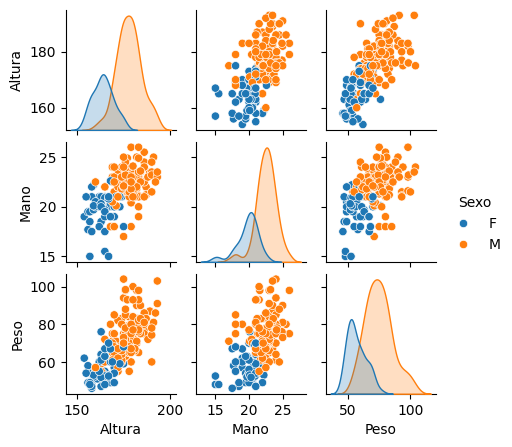

In [4]:
sns.pairplot(datos, hue='Sexo', height=1.5)
plt.savefig('Datos_Ejemplo_Regresion_Logistica.pdf', format='pdf')

In [5]:
datos.groupby('Sexo').mean().round(decimals=1)

,Altura,Mano,Peso
Sexo,,,
F,164.0,19.7,56.9
M,177.8,22.5,74.7


In [6]:
fig = px.scatter_3d(datos, x='Altura', y='Mano', z='Peso', color='Sexo', opacity=0.75)
fig.show()

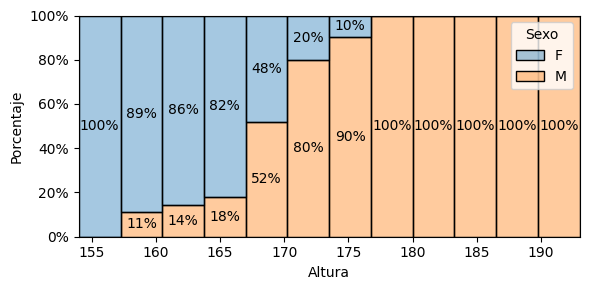

In [7]:
plt.figure(figsize=(6,3))
ax = sns.histplot(data=datos, x='Altura', hue='Sexo', bins=12, multiple='fill', alpha=0.4)
for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.0f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel('Porcentaje')
plt.tight_layout()
plt.savefig('Proporcion_Ejemplo_Regresion_Logistica.pdf', format='pdf')

In [8]:
# Elegir la columna de interés
atributo = 'Altura'
X = datos[atributo]
y = [1 if i=='M' else 0 for i in datos['Sexo']]

In [9]:
# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
# Valores elegidos para b y w
origen = 168.5
w = 0.35
b = -origen*w

In [11]:
# Cálculo de la función sigmoide para cada x
z = b + w * X
predictions = sigmoid(z)
loss = log_loss(y, predictions)

x_new = np.linspace(X.min(),X.max(),400)
z_new = b + w * x_new
predictions_new = sigmoid(z_new)

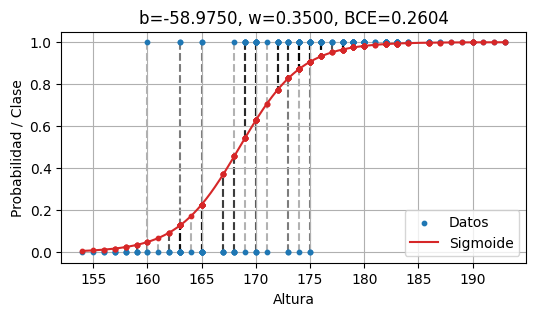

In [12]:
# Gráfico
plt.figure(figsize=(6,3))

# Añadir segmentos punteados
for x_val, y_val, pred in zip(X, y, predictions):
    plt.plot([x_val, x_val], [y_val, pred], 'k--', zorder=1, alpha=0.3)

plt.scatter(X, y, color='tab:blue', label='Datos', zorder=2, s=10)
plt.scatter(X, predictions, color='tab:red', zorder=2, s=10)
plt.plot(x_new, predictions_new, color='tab:red', label='Sigmoide')

plt.xlabel(atributo)
plt.ylabel('Probabilidad / Clase')
plt.title(f'b={b:.4f}, w={w:.4f}, BCE={loss:.4f}')  # Se actualiza el título aquí
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.legend()
plt.grid(True)
#plt.gca().set_axisbelow(True)
plt.savefig('BCE_Sigmoide_Ejemplo_Regresion_Logistica.pdf', format='pdf', bbox_inches = "tight")

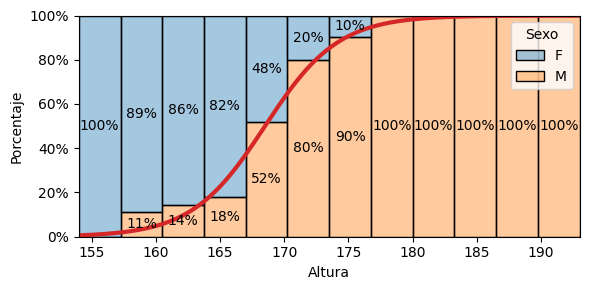

In [13]:
plt.figure(figsize=(6,3))
ax = sns.histplot(data=datos, x='Altura', hue='Sexo', bins=12, multiple='fill', alpha=0.4)
for bars in ax.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.0f}%' if h > 0.001 else '' for h in heights]
    ax.bar_label(bars, labels=labels, label_type='center')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.plot(x_new, predictions_new, color='tab:red', label='Sigmoide', lw=3)
ax.set_ylabel('Porcentaje')
plt.tight_layout()
plt.savefig('Sigmoide_Proporcion_Ejemplo_Regresion_Logistica.pdf', format='pdf')

In [14]:
# Entrenar el modelo de regresión logística
clf = LogisticRegression(solver='newton-cg').fit(X.values.reshape(-1,1), y)
print(clf.coef_, clf.intercept_)

[[0.38197621]] [-64.30404084]


In [15]:
# Estandarizamos
scaler = StandardScaler()
X_std = scaler.fit_transform(X.values.reshape(-1,1))

# Entrenar el modelo de regresión logística
clf = LogisticRegression(solver='newton-cg').fit(X_std, y)

# Obtener los parámetros óptimos
b_optimal = clf.intercept_[0]
w_optimal = clf.coef_[0, 0]

print(f'b: {b_optimal}\nw: {w_optimal}')

b: 1.785682180267692
w: 2.772959247696545


In [16]:
# Calcular la pérdida BCE para un rango de valores alrededor de los parámetros óptimos
b_range = np.linspace(b_optimal - 5, b_optimal + 5, 100)
w_range = np.linspace(w_optimal - 5, w_optimal + 5, 100)

B, W = np.meshgrid(b_range, w_range)

L = np.zeros((W.shape[0], B.shape[1]))
for i in range(W.shape[0]):
    for j in range(B.shape[1]):
        p_hat = sigmoid(B[i,j] + W[i,j] * X_std)
        L[i, j] = log_loss(y, p_hat)

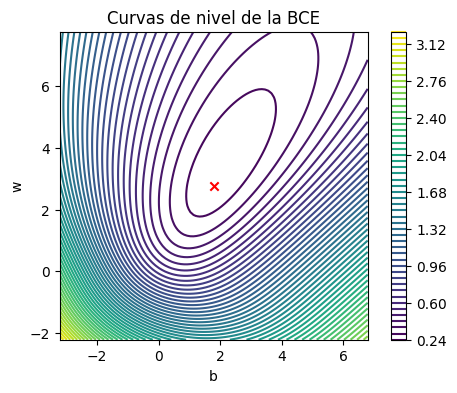

In [17]:
# Graficar las curvas de nivel
plt.figure(figsize=(6,4))
plt.contour(B, W, L, 50)
plt.colorbar()
plt.title('Curvas de nivel de la BCE')
plt.xlabel('b')
plt.ylabel('w')
plt.scatter(b_optimal, w_optimal, color='red', marker='x')  # parámetros óptimos
plt.gca().set_aspect('equal')
plt.savefig('BCE_Curvas_Ejemplo_Regresion_Logistica.pdf', format='pdf')

In [18]:
X = datos[['Altura', 'Mano']]

# Entrenar el modelo de regresión logística
clf = LogisticRegression(solver='newton-cg').fit(X, y)
print(clf.coef_, clf.intercept_)

[[0.31617112 0.77288572]] [-69.32731221]


In [19]:
b = clf.intercept_[0]
w_A = clf.coef_[0,0]
w_M = clf.coef_[0,1]

a_range = np.linspace(X['Altura'].min(), X['Altura'].max(), 100)
m_range = np.linspace(X['Mano'].min(), X['Mano'].max(), 100)

A, M = np.meshgrid(a_range,m_range)
Z = b + w_A * A + w_M * M
P = 1 / (1 + np.exp(-Z))

In [33]:
#Using Plotly
fig = (go.Figure(data=[go.Surface(z=P, x=A, y=M, opacity = 0.7)]))

fig.add_scatter3d(x=X['Altura'].values.flatten(),
                  y=X['Mano'].values.flatten(),
                  z=np.array(y).flatten(),
                  mode='markers',
                  marker=dict(size=5, color=np.array(y).flatten(), colorscale='haline',opacity=0.9))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
camera = dict(
    eye=dict(x=0.5, y=-0.4, z=0.25)
)
fig.update_layout(scene_camera=camera)
fig.layout.scene.camera.projection.type = "orthographic"
fig.write_image('Sigmoide_2D_Ejemplo_Regresion_Logistica.pdf')
fig.show()